# **Remove/Pick up electric? noise**
If you apply fourier transform to clean data, you'll found additional periodic noise.  
This may be a important feature. I introduce a way to treat this noise.  
I don't know how it would affect the prediction. If you have verified, Teach me!  
(I found the word "Kalman filter" several times, is it related?)
  
Thanks to Chris Deotte for [clean data](https://www.kaggle.com/cdeotte/data-without-drift)!

 **! <span style="color: red; ">I changed function "bandpass" and "bandstop". The instructions are in the comments. </span>! **

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import os.path as path
import numpy.fft as fft
from scipy import signal as scisig
from sklearn.linear_model import LinearRegression

# **Preprocessing** (useing clean data)

In [2]:
dataset_path = path.join("..", "input")
csv_name = "train_clean.csv"
train = read_csv(path.join(dataset_path, csv_name))
time = train["time"].values
signal = train["signal"].values
channels = train["open_channels"].values

In [3]:
# Apart 2 type
# exclude batch 5,8,10
signalA = np.hstack((signal[:2000000], signal[2500000:3500000], signal[4000000:4500000]))
channelsA = np.hstack((channels[:2000000], channels[2500000:3500000], channels[4000000:4500000]))

# Fill odd value to median
# model 1
signal1 = signal[:1000000]
channels1 = channels[:1000000]
median = np.median(signal1[channels1 == 0])
condition = (signal1 > -1) & (channels1 == 0) # remove noise
signal1[condition] = median
signalA[:1000000] = signal1

# batch 5&10
signalB = np.hstack((signal[2000000:2500000], signal[4500000:]))
channelsB = np.hstack((channels[2000000:2500000], channels[4500000:]))

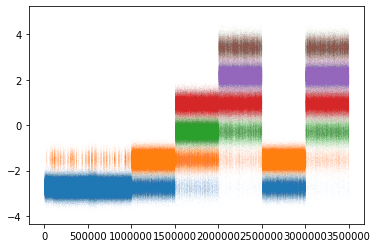

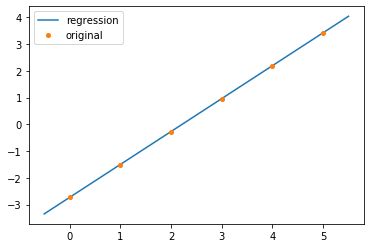

meanA : [-2.73135856 -1.49979538 -0.26823219  0.963331    2.19489419  3.42645737]


In [4]:
# Visual data (type A)

signal = signalA
channels = channelsA

c = 6   # channel size
label = np.arange(len(signal))

channel_list = np.arange(c)
n_list = np.empty(c)
mean_list = np.empty(c)
std_list = np.empty(c)
stderr_list = np.empty(c)

for i in range(c):
    x = label[channels == i]
    y = signal[channels == i]
    n_list[i] = np.size(y)
    mean_list[i] = np.mean(y)
    std_list[i] = np.std(y)
    plt.plot(x, y, ".", markersize = 0.5, alpha = 0.02)
    
stderr_list = std_list / np.sqrt(n_list)
plt.show()


# Predict general mean

w = 1 / stderr_list
channel_list = channel_list.reshape(-1, 1)
linreg_m = LinearRegression()
linreg_m.fit(channel_list, mean_list, sample_weight = w)

mean_predictA = linreg_m.predict(channel_list)

x = np.linspace(-0.5, 5.5, 5)
y = linreg_m.predict(x.reshape(-1, 1))
plt.plot(x, y, label = "regression")
plt.plot(channel_list, mean_list, ".", markersize = 8, label = "original")
plt.legend()
plt.show()

print("meanA :", mean_predictA)

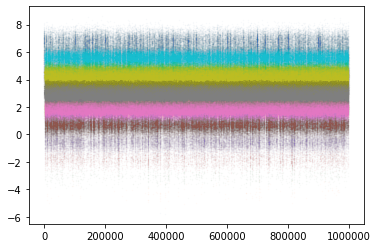

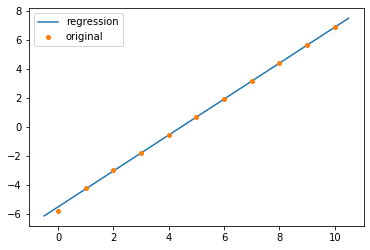

meanB : [-5.49309926 -4.25506493 -3.0170306  -1.77899627 -0.54096195  0.69707238
  1.93510671  3.17314104  4.41117536  5.64920969  6.88724402]


In [5]:
# Visual data (type B)

signal = signalB
channels = channelsB
label = np.arange(len(channels))

c = 11   # channel size

channel_list = np.arange(c)
n_list = np.empty(c)
mean_list = np.empty(c)
std_list = np.empty(c)
stderr_list = np.empty(c)

for i in range(c):
    x = label[channels == i]
    y = signal[channels == i]
    n_list[i] = np.size(y)
    mean_list[i] = np.mean(y)
    std_list[i] = np.std(y)
    plt.plot(x, y, ".", markersize = 0.7, alpha = 0.03)
    
stderr_list = std_list / np.sqrt(n_list)
plt.show()


# Predict general mean

w = 1 / stderr_list
channel_list = channel_list.reshape(-1, 1)
linreg_m = LinearRegression()
linreg_m.fit(channel_list, mean_list, sample_weight = w)

mean_predictB = linreg_m.predict(channel_list)

x = np.linspace(-0.5, 10.5, 5)
y = linreg_m.predict(x.reshape(-1, 1))
plt.plot(x, y, label = "regression")
plt.plot(channel_list, mean_list, ".", markersize = 8, label = "original")
plt.legend()
plt.show()

print("meanB :", mean_predictB)

In [6]:
def Arrange_mean(signal, channels, diff, channel_range):
    signal_out = signal.copy()
    for i in range(channel_range):
        signal_out[channels == i] -= diff[i]
    return signal_out

def bandstop(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandstop")
    y = scisig.filtfilt(b, a, x)
    return y

def bandpass(x, samplerate = 1000000, fp = np.array([4925, 5075]), fs = np.array([4800, 5200])):
    fn = samplerate / 2   # Nyquist frequency
    wp = fp / fn
    ws = fs / fn
    gpass = 1
    gstop = 10.0

    N, Wn = scisig.buttord(wp, ws, gpass, gstop)
    b, a = scisig.butter(N, Wn, "bandpass")
    y = scisig.filtfilt(b, a, x)
    return y

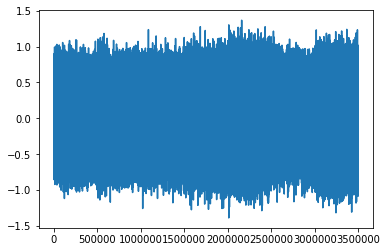

In [7]:
sig_A = Arrange_mean(signalA, channelsA, mean_predictA, 6)
plt.plot(sig_A)
plt.show()

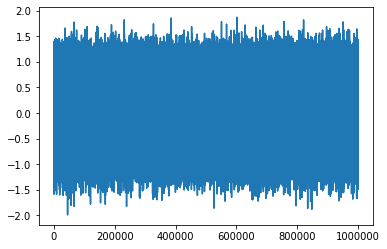

In [8]:
sig_B = Arrange_mean(signalB, channelsB, mean_predictB, 11)
plt.plot(sig_B)
plt.show()

# **Fourier transform**
This data has periodic noise in addition to the gaussian noise

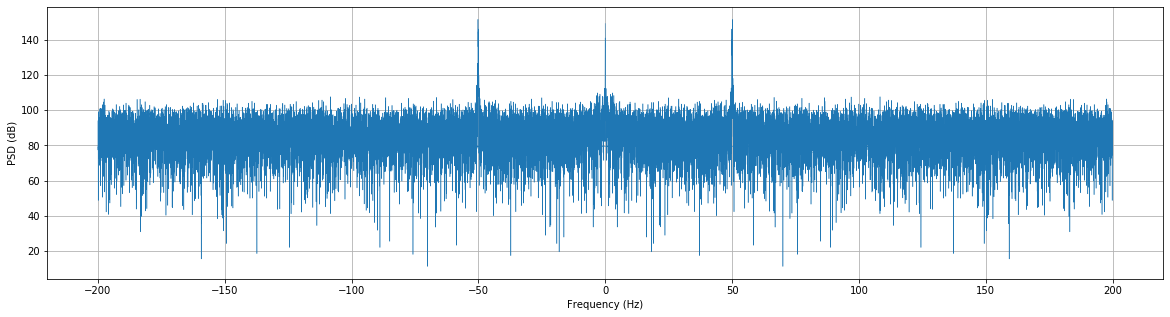

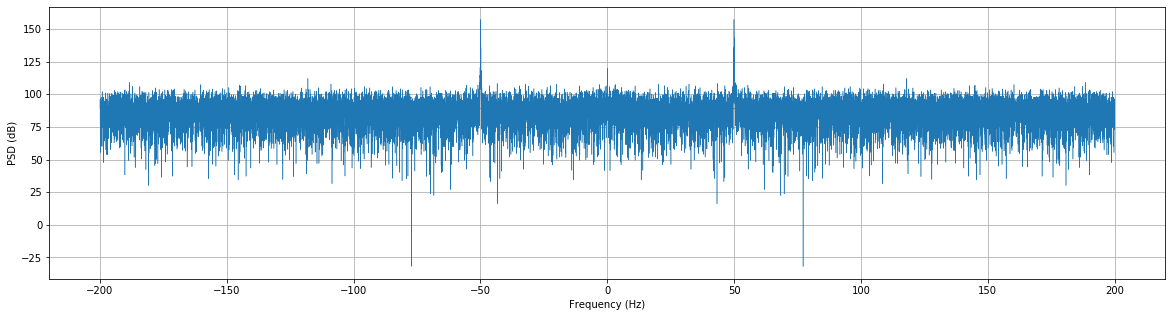

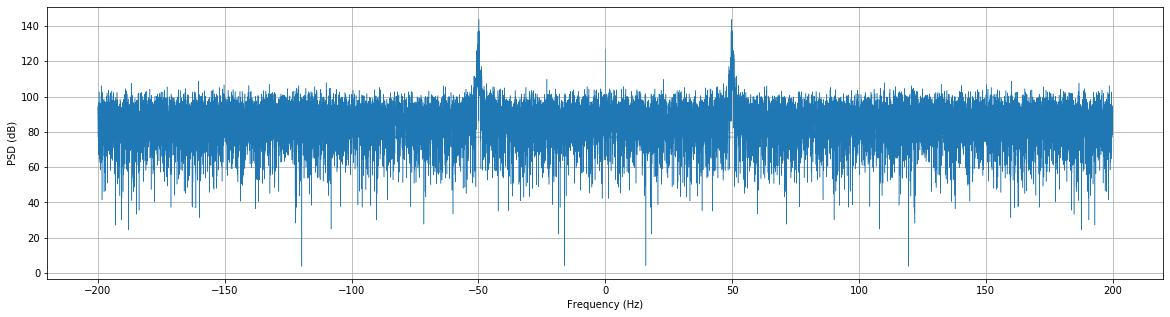

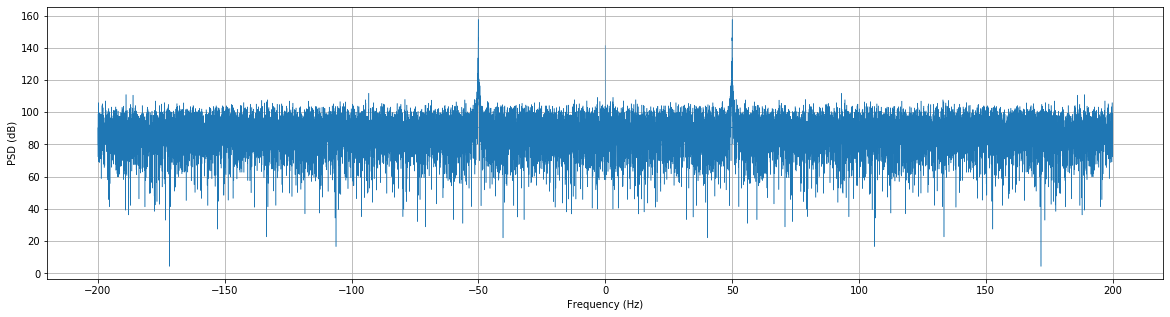

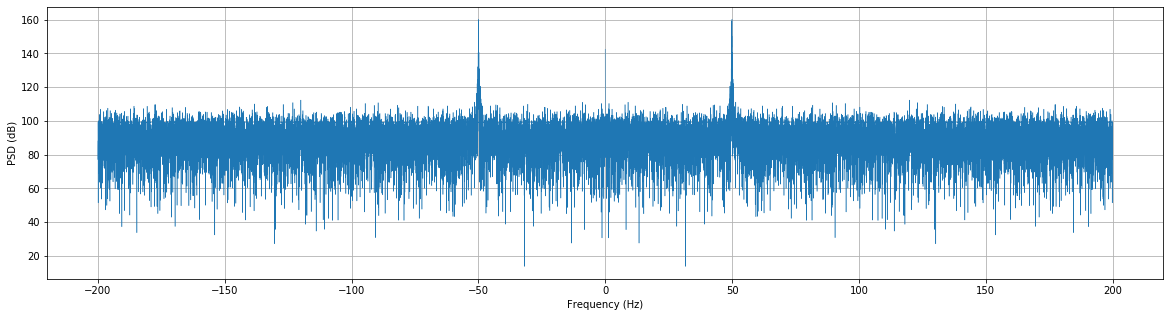

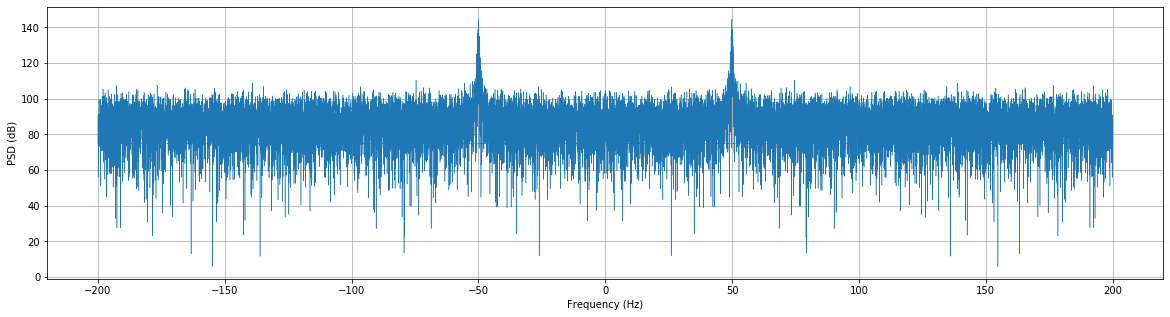

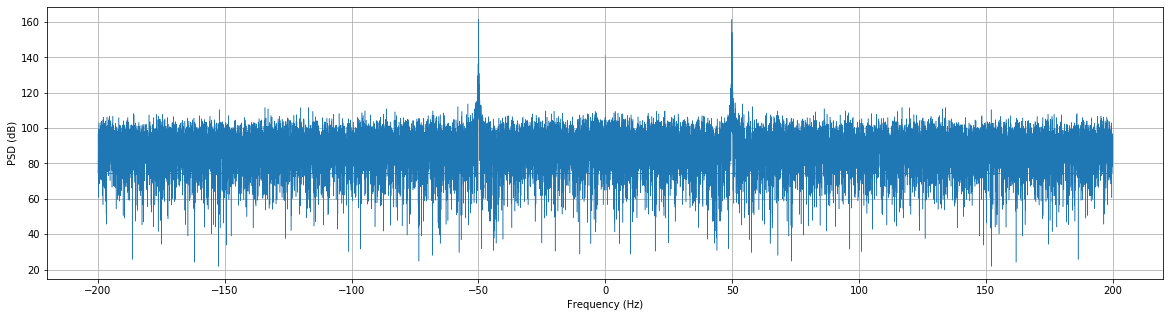

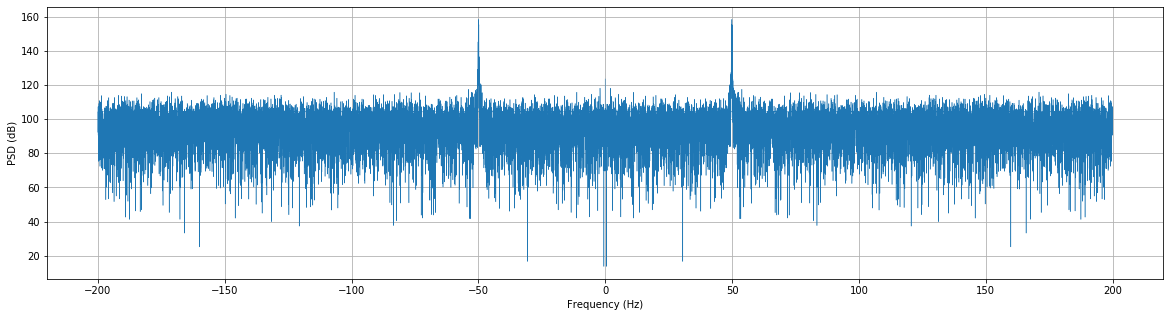

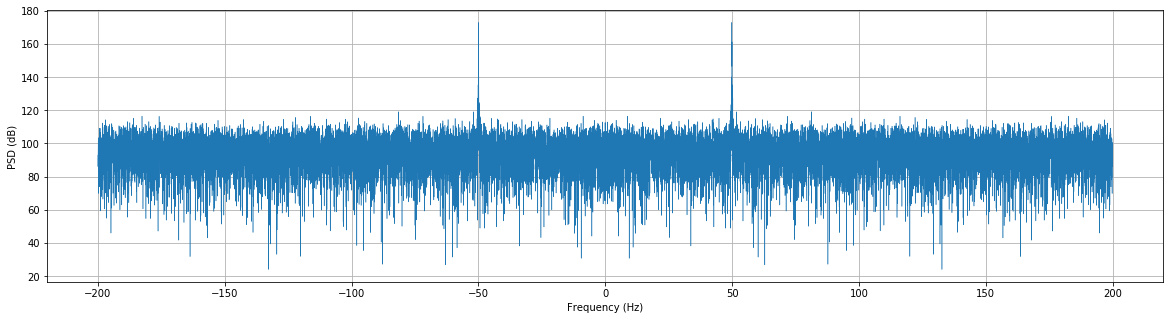

In [9]:
signal_flat = np.hstack((sig_A, sig_B))
sig_list = np.split(signal_flat, 9)
fs=10000.
for sig_sample in sig_list:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig.subplots_adjust(hspace = .5)

    fft = np.fft.fft(sig_sample)
    psd = np.abs(fft) ** 2
    fftfreq = np.fft.fftfreq(len(psd),1/fs)
    
    i = abs(fftfreq) < 200
    ax.grid()
    ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    ax.set_xlabel('Frequency (Hz)') 
    ax.set_ylabel('PSD (dB)')
    plt.show()

# **Remove noise by Bandstop filter**

In [10]:
sig_sample.shape

(500000,)

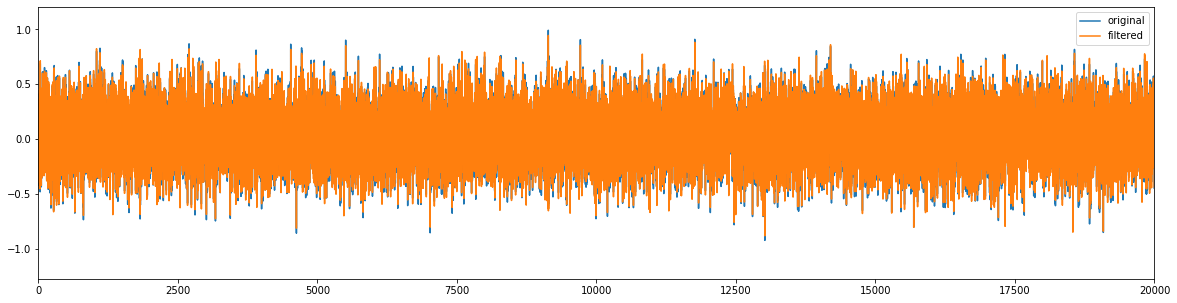

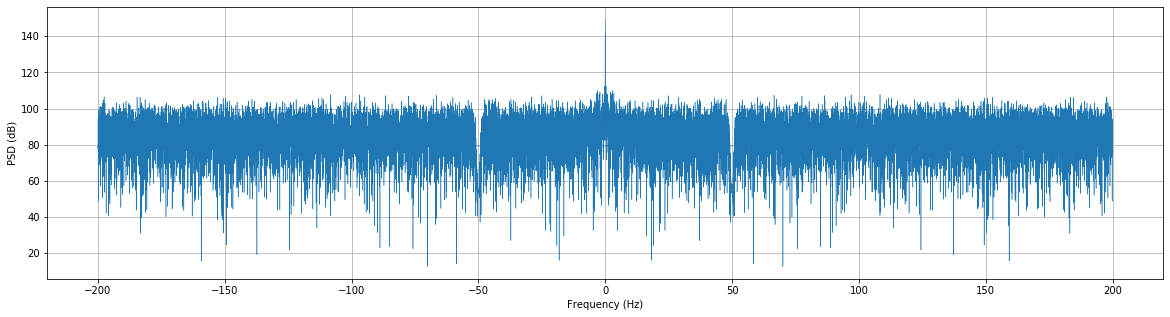

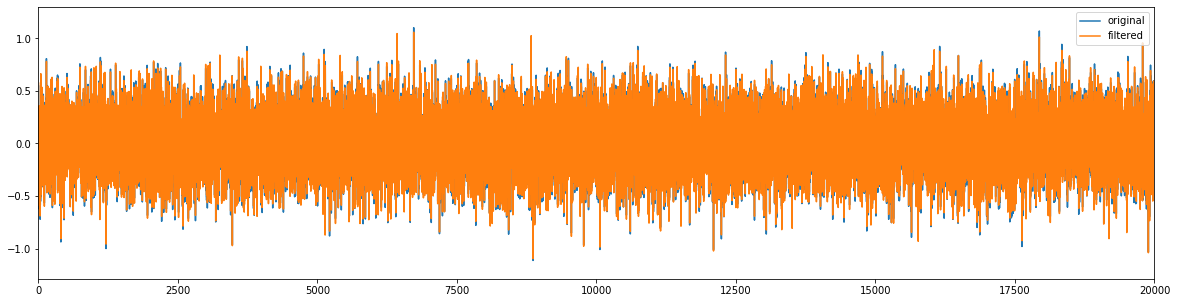

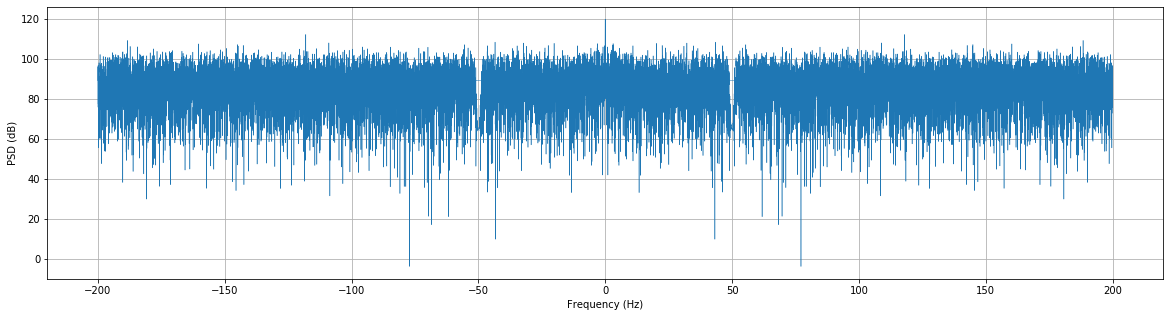

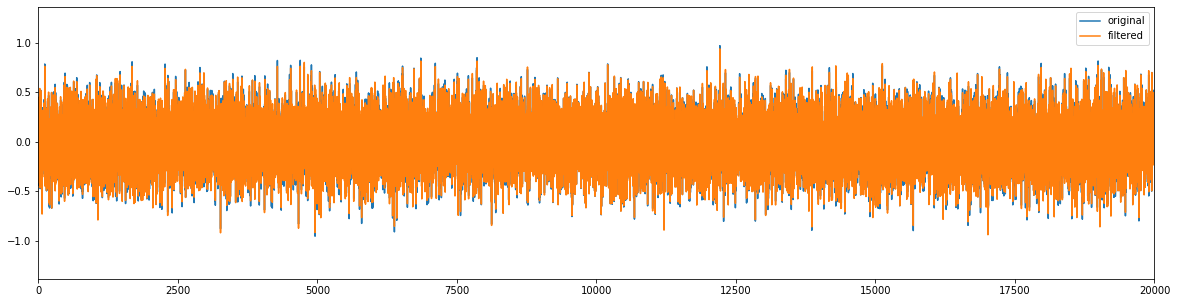

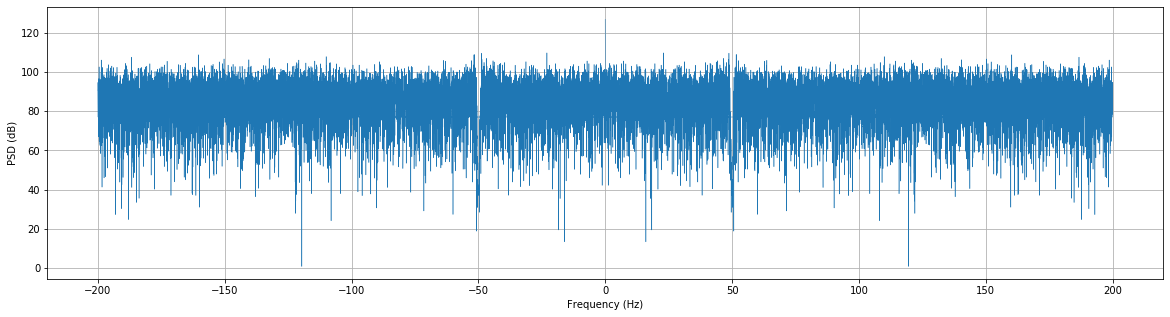

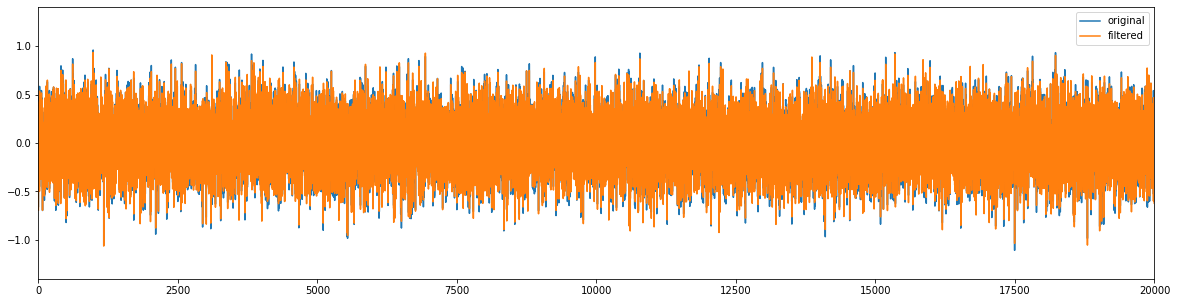

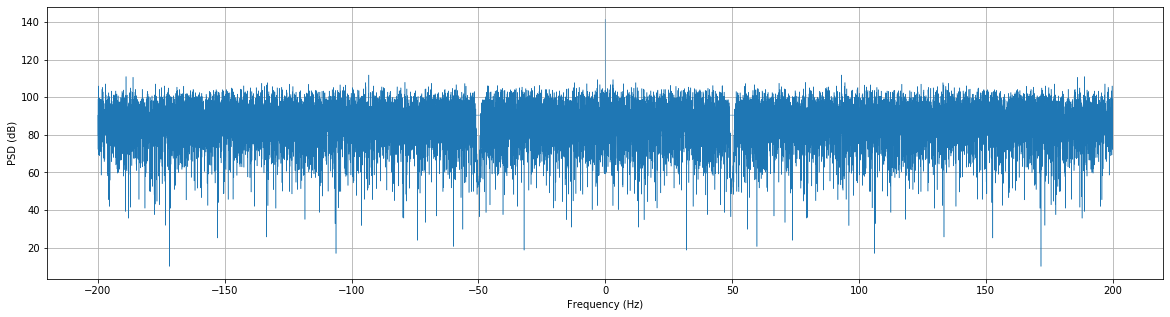

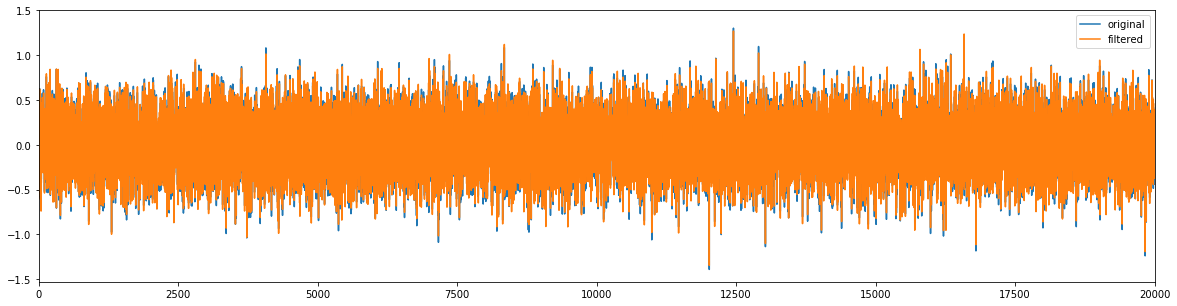

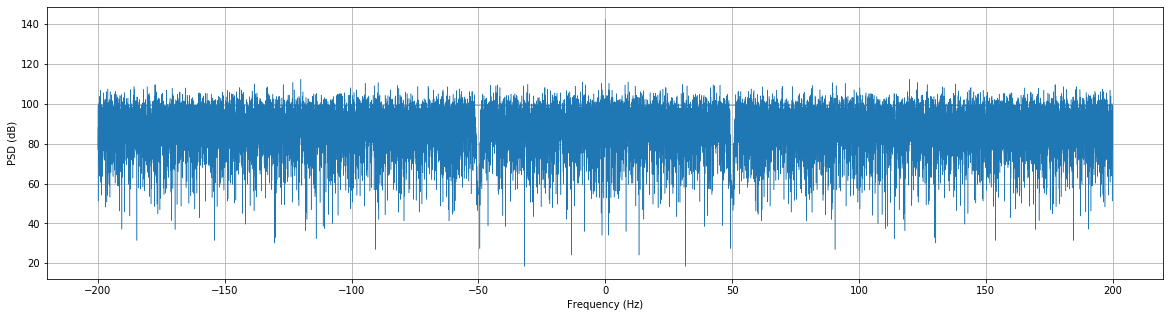

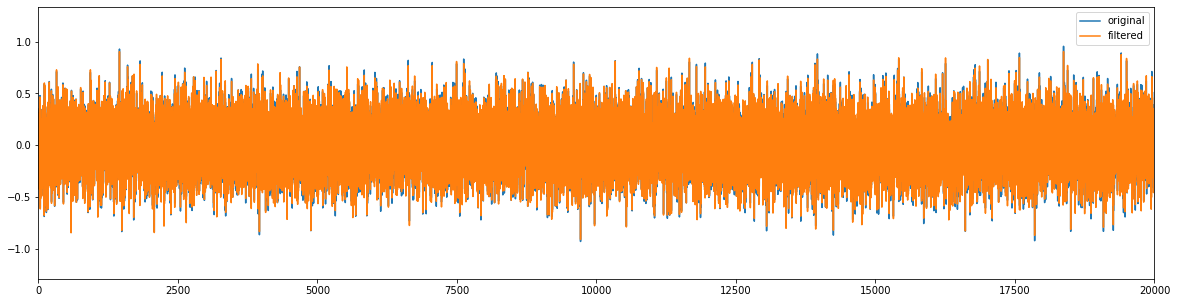

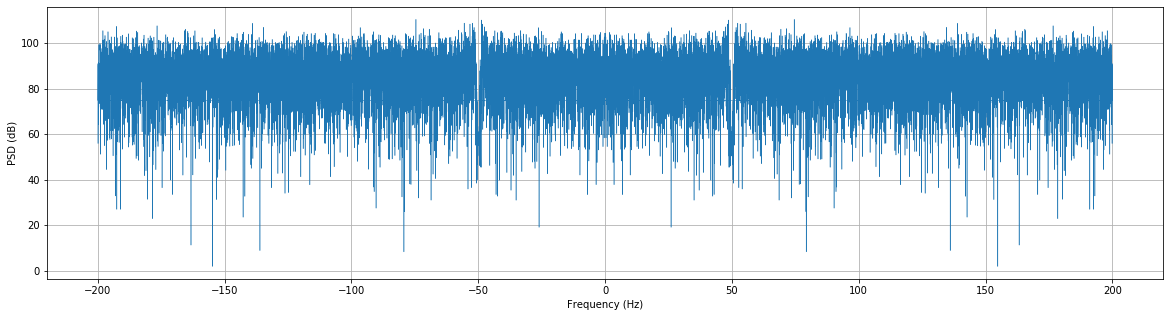

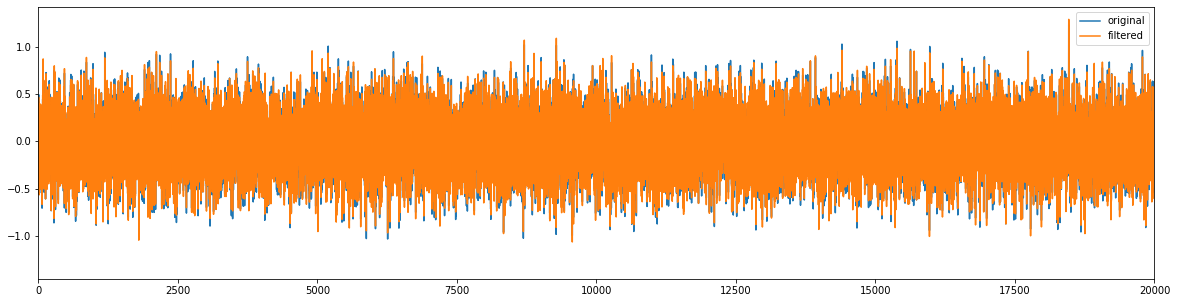

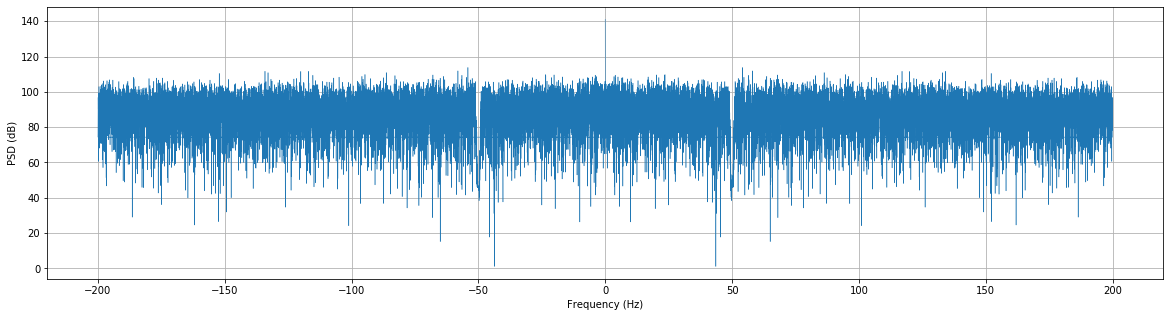

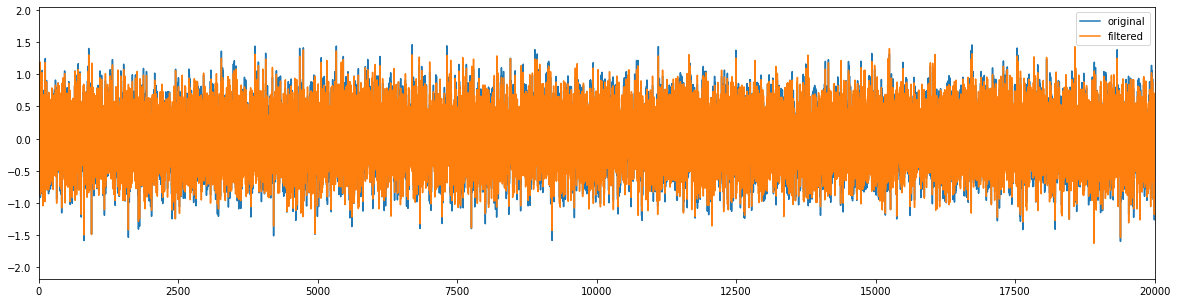

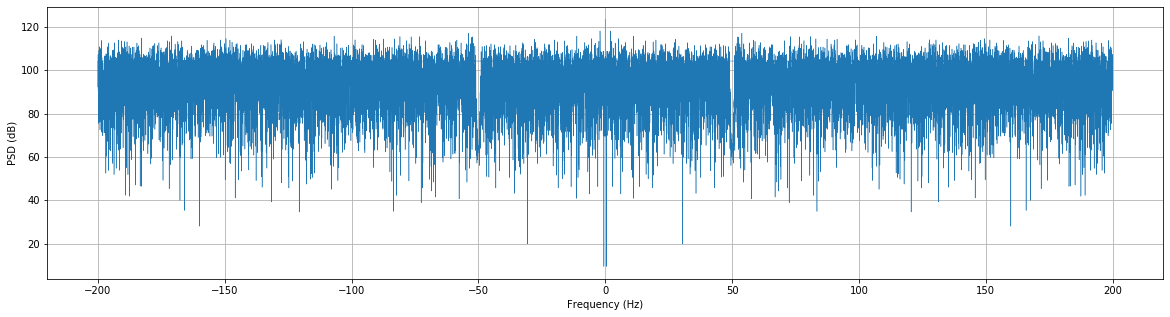

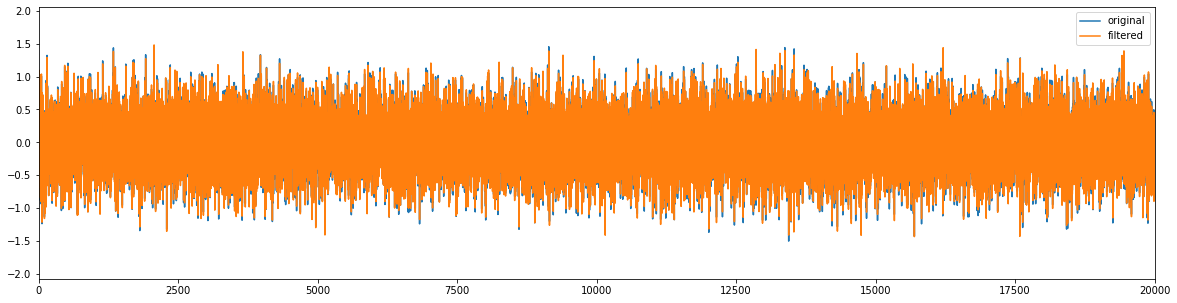

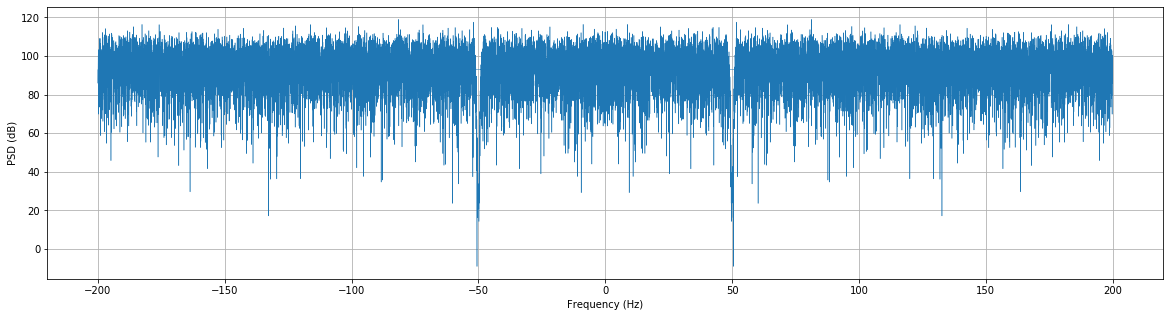

In [11]:
for sig_sample in sig_list:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig.subplots_adjust(hspace = .5)
    sig_remove = bandstop(sig_sample)
    ax.plot(sig_sample, label = "original")
    ax.plot(sig_remove, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlim(0, 20000)
    plt.show()
    
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig.subplots_adjust(hspace = .5)
    fft = np.fft.fft(sig_remove)
    psd = np.abs(fft) ** 2
    fftfreq = np.fft.fftfreq(len(psd),1/fs)
    
    i = abs(fftfreq) < 200
    ax.grid()
    ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
    ax.set_xlabel('Frequency (Hz)') 
    ax.set_ylabel('PSD (dB)')
    plt.show()

# **Pick up noise by Bandpass filter**

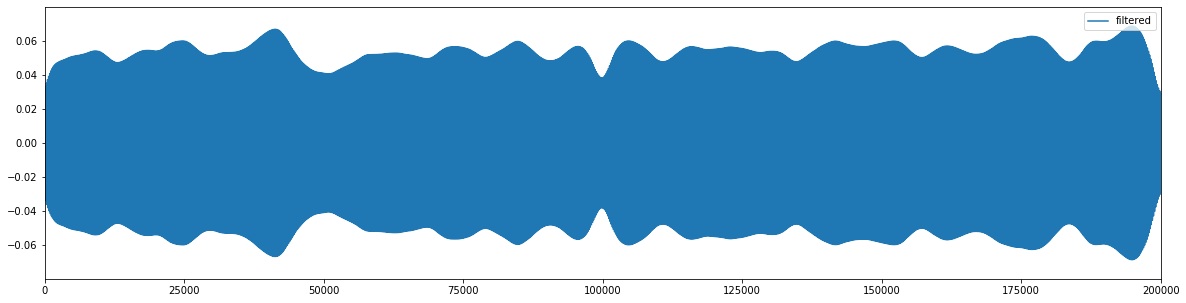

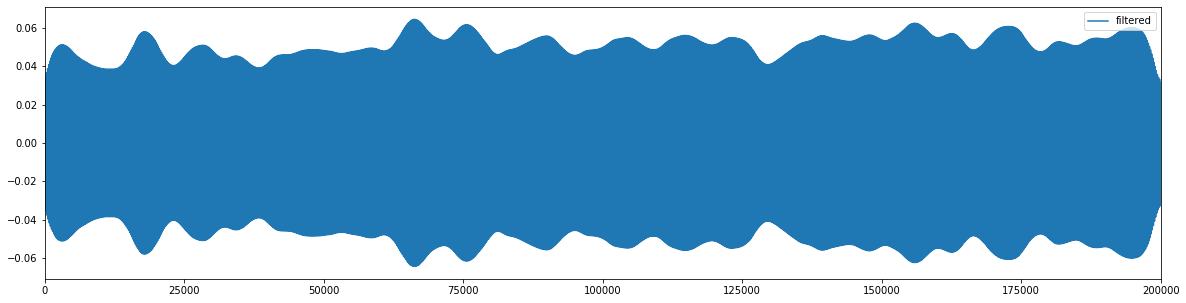

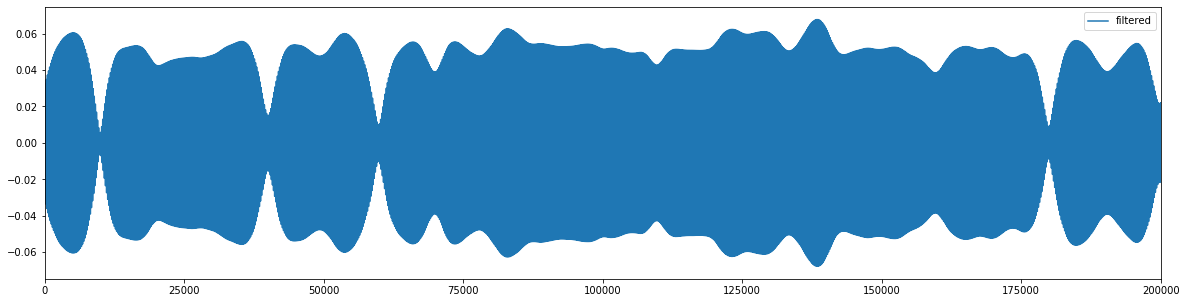

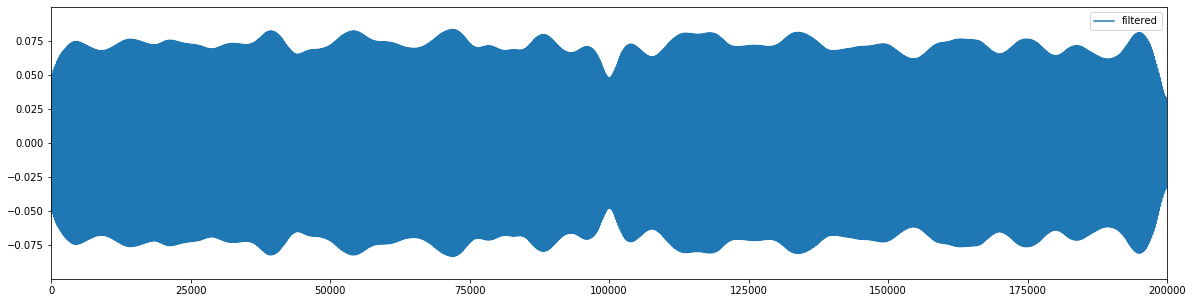

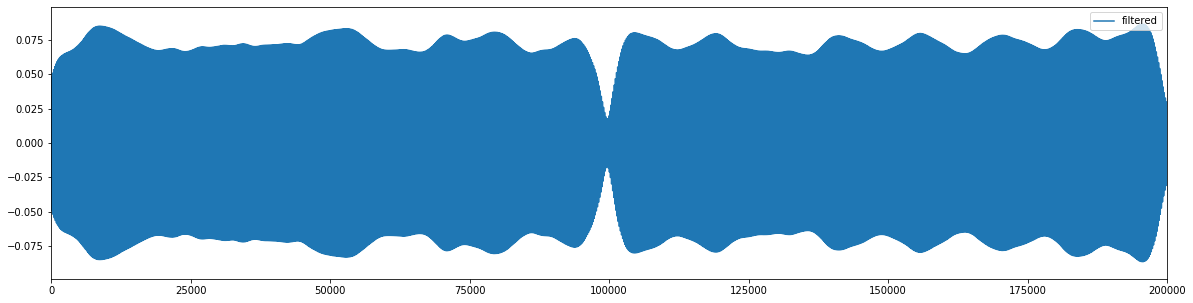

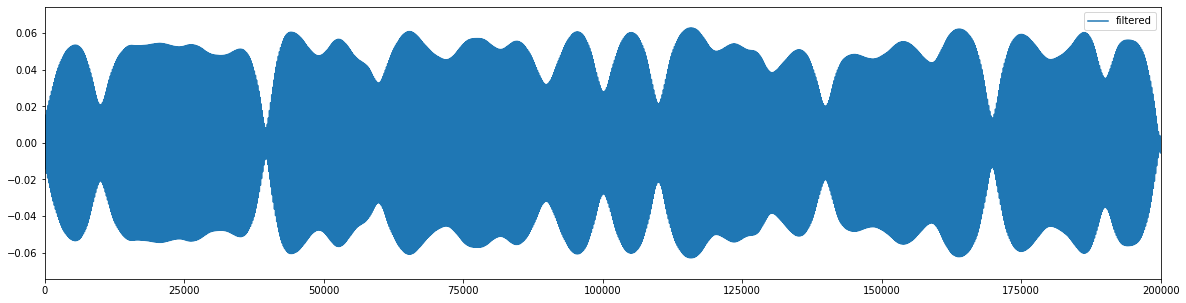

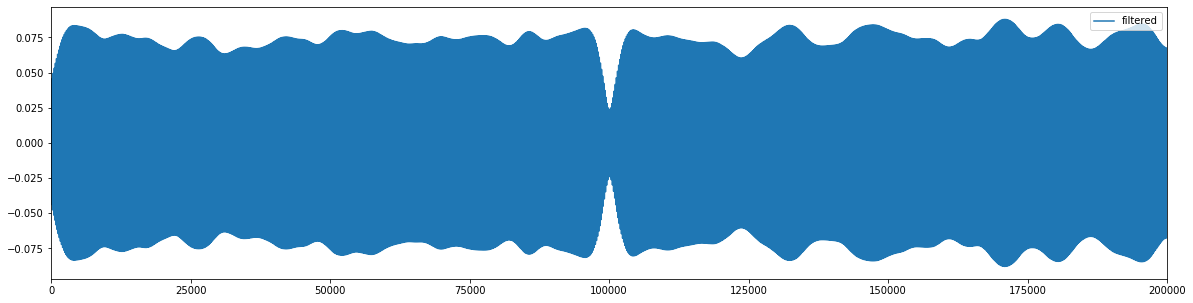

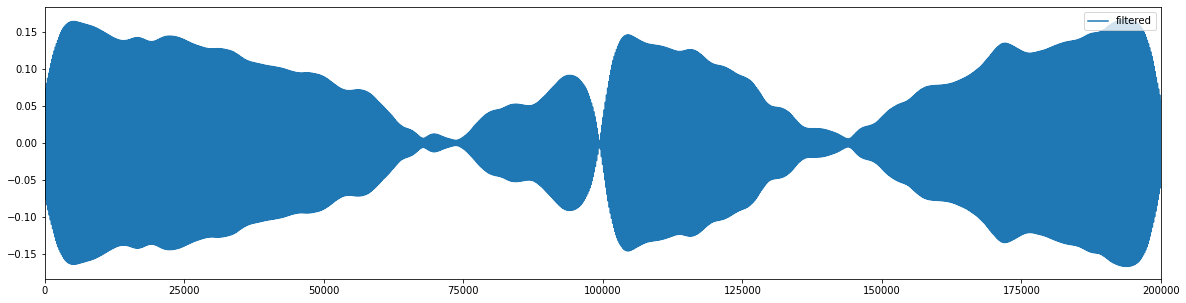

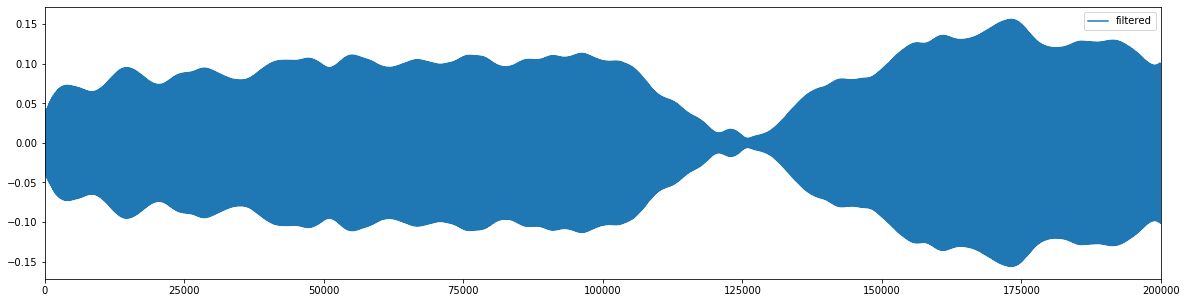

In [19]:
for sig_sample in sig_list:
    sig_remove = bandpass(sig_sample)
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
    fig.subplots_adjust(hspace = .5)
#     ax.plot(sig_sample, label = "original")
    ax.plot(sig_remove, label = "filtered")
    ax.legend(loc = "upper right")
    ax.set_xlim(0, 200000)
    plt.show()
    
    
#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 5))
#     fig.subplots_adjust(hspace = .5)
#     fft = np.fft.fft(sig_remove)
#     psd = np.abs(fft) ** 2
#     fftfreq = np.fft.fftfreq(len(psd),1/fs)   
#     i = abs(fftfreq) < 200
#     ax.grid()
#     ax.plot(fftfreq[i], 20*np.log10(psd[i]), linewidth=.5)
#     ax.set_xlabel('Frequency (Hz)') 
#     ax.set_ylabel('PSD (dB)')
#     plt.show()